<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_03_18_jraph_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks in JAX

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/O1zGWMEgW7A).

## Acknowledgment:
I borrowed some code from [Introduction to Graph Neural Nets with JAX/jraph](https://colab.research.google.com/github/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb#scrollTo=1n1kCuqtkvfm) and [Jraph's train_flax.py](https://github.com/google-deepmind/jraph/blob/51f5990104f7374492f8f3ea1cbc47feb411c69c/jraph/ogb_examples/train_flax.py#L51).

## References:
```bibtex
@software{jax2018github,
 author   = {James Bradbury and Roy Frostig and Peter Hawkins and Matthew James Johnson and Chris Leary and Dougal Maclaurin and George Necula and Adam Paszke and Jake Vander{P}las and Skye Wanderman-{M}ilne and Qiao Zhang},
 title    = {{JAX}: composable transformations of {P}ython+{N}um{P}y programs},
 url      = {http://github.com/google/jax},
 version  = {0.3.13},
 year     = {2018},
}
```
```bibtex
@article{velickovic2018graph,
 title    ="{Graph Attention Networks}",
author    ={Veli{\v{c}}kovi{\'{c}}, Petar and Cucurull, Guillem and Casanova, Arantxa and Romero, Adriana and Li{\`{o}}, Pietro and Bengio, Yoshua},
journal   ={International Conference on Learning Representations},
year      ={2018},
}
```

## Import libraries

In [ ]:
# install pytorch_geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# install jraph and jax dependencies
!pip install git+https://github.com/deepmind/jraph.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-zhqx53w3
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-zhqx53w3
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done


In [ ]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear

# PyTorch geometric
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import (Planetoid, KarateClub)
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from torch_geometric import seed_everything

# jax
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import flax
import flax.linen as nn
from flax.training import train_state
import optax
import pickle

# jraph
import jraph
from jraph._src import models as jraph_models

In [ ]:
random_seed = 42
plt.style.use('dark_background')
accuracy_list = []

## Import Cora Dataset
You can find a description of this dataset in [Pytorch-Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid). In case of `split='full'`, all nodes except those in the validation and test sets will be used for training.

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', split='full', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]  # Get the first graph object.
data_Cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
graph = jraph.GraphsTuple(
      n_node=jnp.asarray([data_Cora.x.shape[0]]),
      n_edge=jnp.asarray([data_Cora.edge_index.shape[1]]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(data_Cora.x.shape[0]),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([data_Cora.edge_index[0,:]]).squeeze(),
      receivers=jnp.asarray([data_Cora.edge_index[1,:]]).squeeze())

graph_train_mask = jnp.asarray([data_Cora.train_mask]).squeeze()
graph_val_mask = jnp.asarray([data_Cora.val_mask]).squeeze()
graph_test_mask = jnp.asarray([data_Cora.test_mask]).squeeze()
graph_labels = jnp.asarray([data_Cora.y]).squeeze()
one_hot_labels = jax.nn.one_hot(graph_labels, len(jnp.unique(graph_labels)))

Let's check if we have the right number of nodes and edges. We also want to check if we have the correct data types `float32` instead of `torch.float32`

In [ ]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')
print(f'Feature matrix data type: {graph.nodes.dtype}')
print(f'senders list data type:   {graph.senders.dtype}')
print(f'receivers list data type: {graph.receivers.dtype}')
print(f'Labels matrix data type:  {graph_labels.dtype}')

Number of nodes: 2708
Number of edges: 10556
Feature matrix data type: float32
senders list data type:   int32
receivers list data type: int32
Labels matrix data type:  int32


## GAT Layers from Jraph

In [ ]:
# Functions must be passed to jraph GNNs, but pytype does not recognise
# linen Modules as callables to here we wrap in a function.
def make_embed_fn(latent_size):
  def embed(inputs):
    return nn.Dense(latent_size)(inputs)
  return embed

def _attention_logit_fn(sender_attr: jnp.ndarray,
                        receiver_attr: jnp.ndarray,
                        edges: jnp.ndarray) -> jnp.ndarray:
  del edges
  x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
  return nn.Dense(1)(x)

In [ ]:
class GAT(nn.Module):
  """Defines a GAT network using FLAX

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gat1_output_dim: int
  gat2_output_dim: int
  output_dim: int

  @nn.compact
  def __call__(self, x):
    gat1 = jraph.GAT(attention_query_fn=lambda n: make_embed_fn(self.gat1_output_dim)(n),
                          attention_logit_fn=_attention_logit_fn,
                          node_update_fn=None)
    gat2 = jraph.GAT(attention_query_fn=lambda n: make_embed_fn(self.gat2_output_dim)(n),
                          attention_logit_fn=_attention_logit_fn,
                          node_update_fn=nn.Dense(self.output_dim))
    return gat2(gat1(x))

You might ask where did we applied nonlinearity?

by setting `node_update_fn=None` we are allowing `jraph.GAT` to apply the default nonlinear function, which is `jax.nn.leaky_relu(x)` as you can see from this code snippet taken from the [source code](https://github.com/google-deepmind/jraph/blob/master/jraph/_src/models.py):

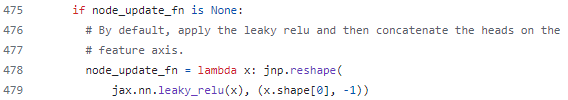

In [ ]:
model = GAT(8, 8, len(jnp.unique(graph_labels)))
model

GAT(
    # attributes
    gat1_output_dim = 8
    gat2_output_dim = 8
    output_dim = 7
)

## Optimizer and Loss
We set the optimizer to adam using `optax` library. Then we initialized the model using random parameters.

In [ ]:
optimizer = optax.adam(learning_rate=0.01)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(random_seed), 3)
params = model.init(jax.random.PRNGKey(random_seed),graph)

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

## The problem of masking under `@jax.jit`

For the loss function, we used cross entropy inside `compute_loss` function to evaluate the model predictions. The problem arises when we try to mask the model output for each `train\val\test` separately. We cannot use Boolean indexing under `@jax.jit`, it will throw `NonConcreteBooleanIndexError` which is shown in the screenshot below. You can read about this error [here](https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError). Jax's jit compilation requires that all array shapes to be known at compile time. This can't be done with Boolean indexing.

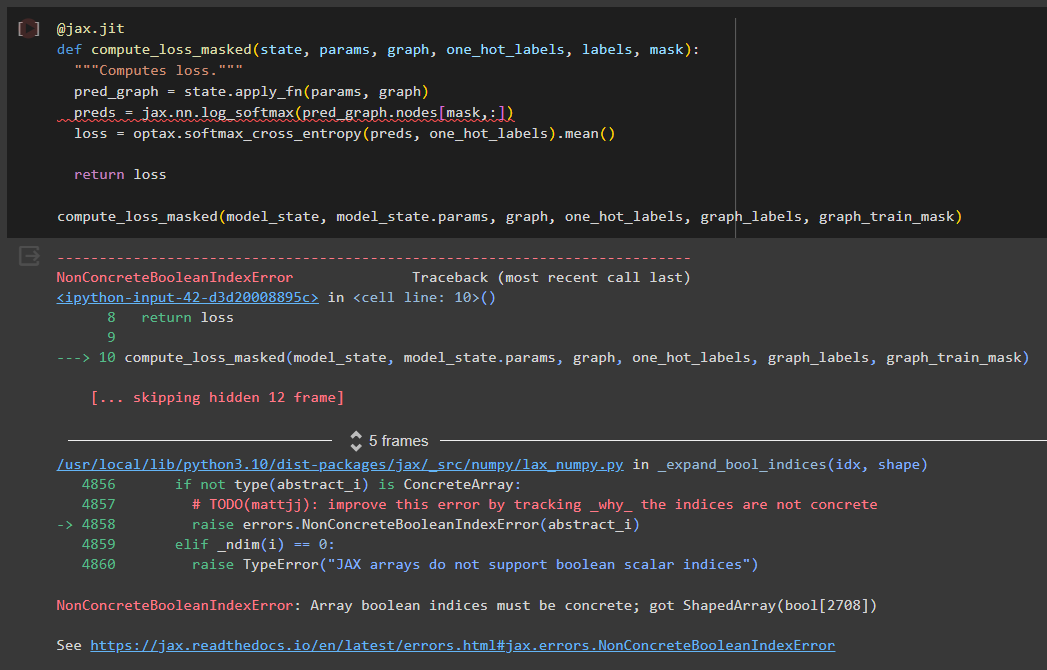

So we have to get back to the basics!!

To avoid the error above, Jax recommends using `jnp.where`. We passed the mask to `compute_loss` function and we compute the losses without masking. We used `jnp.where` on the loss array to set the masked nodes to zero, then we sum up the rest. This will gives us the `sum` needed to compute the `mean`. For `count`, we sum up the mask entries. Because it is only ones and zeros it will return how many nodes in the mask. Dividing `sum` by `count` gives us the mean loss for the nodes in the mask.

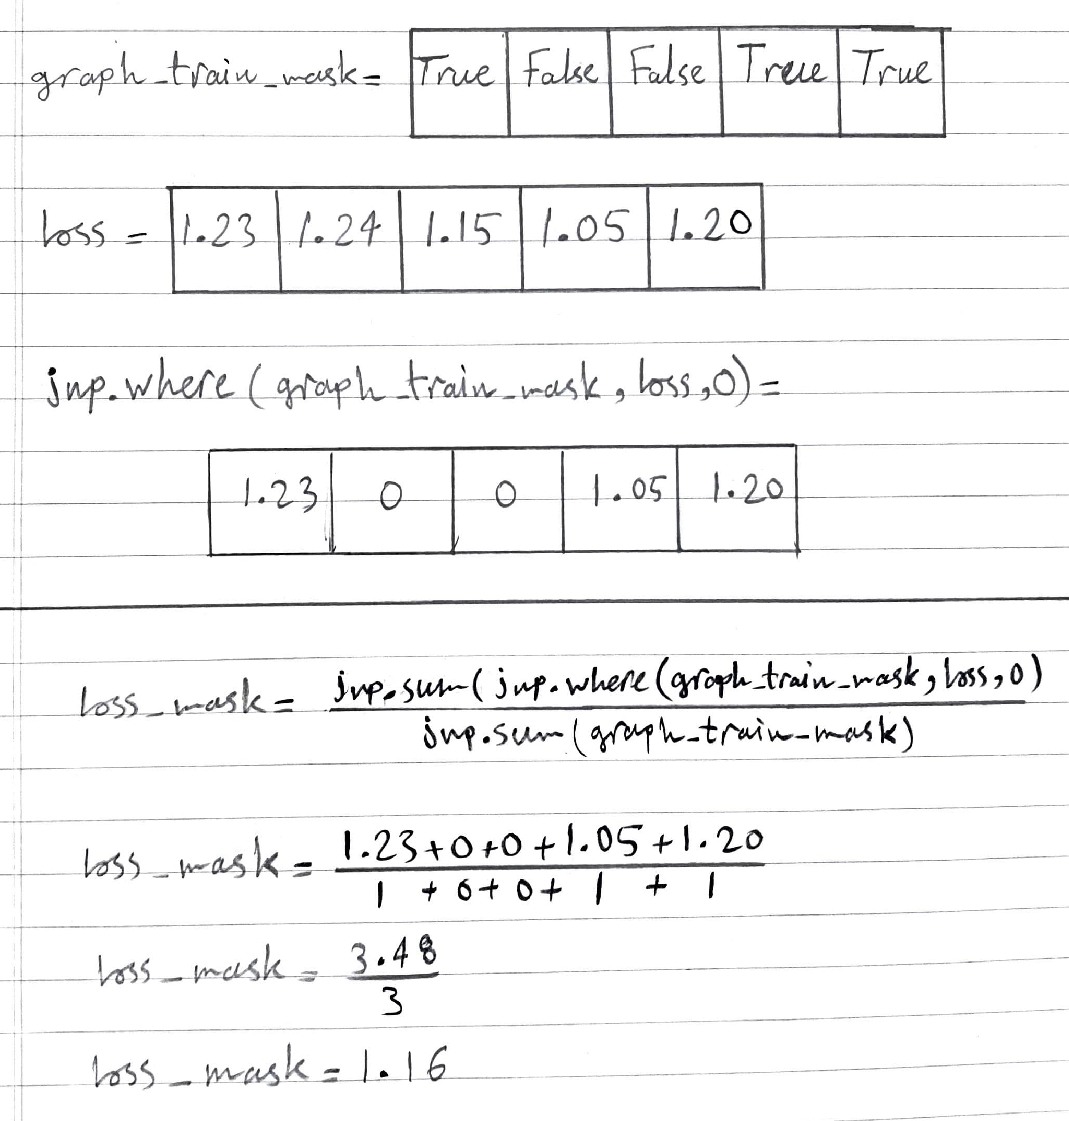

In [ ]:
def compute_loss(state, params, graph, labels, one_hot_labels, mask):
  """Computes loss."""
  pred_graph = state.apply_fn(params, graph)
  preds = jax.nn.log_softmax(pred_graph.nodes)
  loss = optax.softmax_cross_entropy(preds, one_hot_labels)
  loss_mask = jnp.sum(jnp.where(mask, loss, 0)) / jnp.sum(mask)

  pred_labels = jnp.argmax(preds, axis=1)
  acc = (pred_labels == labels)
  acc_mask = jnp.sum(jnp.where(mask, acc, 0)) / jnp.sum(mask)
  return loss_mask, acc_mask

## Training

In [ ]:
@jax.jit  # Jit the function for efficiency
def train_step(state, graph, graph_labels, one_hot_labels, train_mask):
  # Gradient function
  grad_fn = jax.value_and_grad(compute_loss,  # Function to calculate the loss
                                argnums=1,  # Parameters are second argument of the function
                                has_aux=True  # Function has additional outputs, here accuracy
                              )
  # Determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, graph, graph_labels, one_hot_labels, train_mask)
  # Perform parameter update with gradients and optimizer
  state = state.apply_gradients(grads=grads)
  # Return state and any other value we might want
  return state, loss, acc

In [ ]:
def train_model(state, graph, graph_labels, one_hot_labels, train_mask, val_mask, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    state, loss, acc = train_step(state, graph, graph_labels, one_hot_labels, train_mask)
    val_loss, val_acc = compute_loss(state, state.params, graph, graph_labels, one_hot_labels, val_mask)
    print(f'step: {epoch:03d}, train loss: {loss:.4f}, train acc: {acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')
  return state, acc, val_acc

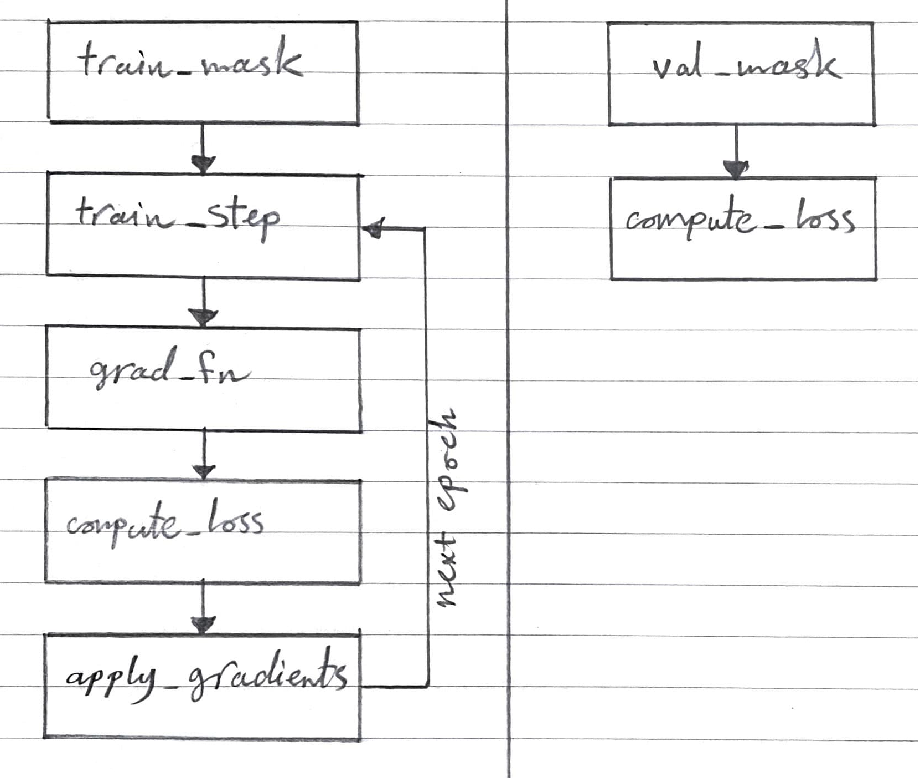

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state, train_acc, val_acc = train_model(model_state, graph, graph_labels, one_hot_labels, graph_train_mask, graph_val_mask, num_epochs=100)
accuracy_list.append(['Cora', 'train', float(train_acc)])
accuracy_list.append(['Cora', 'valid', float(val_acc)])

<IPython.core.display.Javascript object>

step: 000, train loss: 1.9453, train acc: 0.1714, val loss: 1.9278, val acc: 0.3720
step: 001, train loss: 1.9283, train acc: 0.3609, val loss: 1.9062, val acc: 0.3820
step: 002, train loss: 1.9066, train acc: 0.3891, val loss: 1.8812, val acc: 0.3780
step: 003, train loss: 1.8812, train acc: 0.3800, val loss: 1.8539, val acc: 0.3820
step: 004, train loss: 1.8531, train acc: 0.3675, val loss: 1.8247, val acc: 0.3580
step: 005, train loss: 1.8230, train acc: 0.3452, val loss: 1.7942, val acc: 0.3360
step: 006, train loss: 1.7912, train acc: 0.3129, val loss: 1.7627, val acc: 0.3180
step: 007, train loss: 1.7581, train acc: 0.2864, val loss: 1.7303, val acc: 0.3180
step: 008, train loss: 1.7237, train acc: 0.2831, val loss: 1.6972, val acc: 0.3160
step: 009, train loss: 1.6885, train acc: 0.2823, val loss: 1.6638, val acc: 0.3160
step: 010, train loss: 1.6524, train acc: 0.2823, val loss: 1.6303, val acc: 0.3160
step: 011, train loss: 1.6158, train acc: 0.2823, val loss: 1.5968, val acc:

## Testing

In [ ]:
test_loss, test_acc = compute_loss(trained_model_state, trained_model_state.params, graph, graph_labels, one_hot_labels, graph_test_mask)
print(f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
accuracy_list.append(['Cora', 'test', float(test_acc)])

test loss: 1.3145, test acc: 0.7790


## Import CiteSeer Dataset
You can find a description of this dataset in [Pytorch-Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid). In case of `split='full'`, all nodes except those in the validation and test sets will be used for training.

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='CiteSeer', split='full', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_CiteSeer = dataset[0]  # Get the first graph object.
data_CiteSeer

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [ ]:
graph = jraph.GraphsTuple(
      n_node=jnp.asarray([data_CiteSeer.x.shape[0]]),
      n_edge=jnp.asarray([data_CiteSeer.edge_index.shape[1]]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(data_CiteSeer.x.shape[0]),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([data_CiteSeer.edge_index[0,:]]).squeeze(),
      receivers=jnp.asarray([data_CiteSeer.edge_index[1,:]]).squeeze())

graph_train_mask = jnp.asarray([data_CiteSeer.train_mask]).squeeze()
graph_val_mask = jnp.asarray([data_CiteSeer.val_mask]).squeeze()
graph_test_mask = jnp.asarray([data_CiteSeer.test_mask]).squeeze()
graph_labels = jnp.asarray([data_CiteSeer.y]).squeeze()
one_hot_labels = jax.nn.one_hot(graph_labels, len(jnp.unique(graph_labels)))

In [ ]:
model = GAT(8, 8, len(jnp.unique(graph_labels)))
model

GAT(
    # attributes
    gat1_output_dim = 8
    gat2_output_dim = 8
    output_dim = 6
)

In [ ]:
optimizer = optax.adam(learning_rate=0.01)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(random_seed), 3)
params = model.init(jax.random.PRNGKey(random_seed),graph)

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state, train_acc, val_acc = train_model(model_state, graph, graph_labels, one_hot_labels, graph_train_mask, graph_val_mask, num_epochs=100)
accuracy_list.append(['CiteSeer', 'train', float(train_acc)])
accuracy_list.append(['CiteSeer', 'valid', float(val_acc)])

<IPython.core.display.Javascript object>

step: 000, train loss: 1.7922, train acc: 0.1560, val loss: 1.7811, val acc: 0.2200
step: 001, train loss: 1.7804, train acc: 0.2332, val loss: 1.7683, val acc: 0.2820
step: 002, train loss: 1.7648, train acc: 0.2967, val loss: 1.7534, val acc: 0.3480
step: 003, train loss: 1.7455, train acc: 0.3930, val loss: 1.7373, val acc: 0.4300
step: 004, train loss: 1.7237, train acc: 0.4964, val loss: 1.7202, val acc: 0.4620
step: 005, train loss: 1.6998, train acc: 0.5331, val loss: 1.7023, val acc: 0.4780
step: 006, train loss: 1.6741, train acc: 0.5452, val loss: 1.6838, val acc: 0.4780
step: 007, train loss: 1.6466, train acc: 0.5517, val loss: 1.6643, val acc: 0.4800
step: 008, train loss: 1.6170, train acc: 0.5528, val loss: 1.6437, val acc: 0.4800
step: 009, train loss: 1.5851, train acc: 0.5523, val loss: 1.6218, val acc: 0.4820
step: 010, train loss: 1.5506, train acc: 0.5539, val loss: 1.5986, val acc: 0.4840
step: 011, train loss: 1.5136, train acc: 0.5567, val loss: 1.5743, val acc:

In [ ]:
test_loss, test_acc = compute_loss(trained_model_state, trained_model_state.params, graph, graph_labels, one_hot_labels, graph_test_mask)
print(f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
accuracy_list.append(['CiteSeer', 'test', float(test_acc)])

test loss: 2.1916, test acc: 0.5740


## Plotting the results

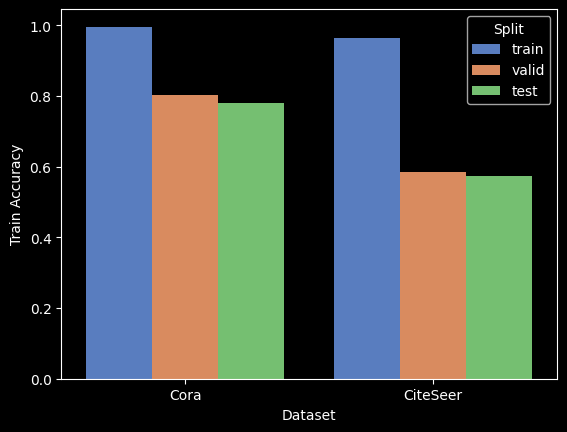

In [ ]:
df = pd.DataFrame(accuracy_list, columns=('Dataset', 'Split', 'Accuracy'))
sns.barplot(df,x='Dataset', y='Accuracy', hue='Split', palette="muted")
plt.show()